## Import libraries

In [1]:
#from tensorflow.compat.v1.keras.models import Sequential
#from tensorflow.compat.v1.keras.layers import Dense
#from tensorflow.compat.v1.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import pandas as pd
import numpy as np
from six import string_types
from six.moves import xrange as range
from numpy import nan
import xlrd

import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
from pylab import *

import sklearn
import xgboost as xgb
import lightgbm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, SCORERS, r2_score
from sklearn import linear_model, neighbors, tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau, spearmanr, pearsonr, variation
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import scipy
import shap
import time


RESULT_PATH = "results/"
FILE_PATH = 'Circ_Dataset.xlsx'

# fix random seed for reproducibility, random to be called before permutations in following blocks
seed = 4191995


## Dataset import and pre-process

In [2]:
# split into input (X) and output (Y) variables
DATA = np.array(pd.read_excel(FILE_PATH))
X = DATA[:,1:8]
XBE = DATA[:,1:10]
Y = DATA[:,10:13]
Y = np.where(Y==0,np.nan,Y) 

#X = pd.DataFrame(X)
#print(X.info())
#Y = pd.DataFrame(Y)
#print(Y.info())

# Shuffle data
np.random.seed(seed)
p = np.random.permutation(len(X))
X = X[p]
np.random.seed(seed)
p = np.random.permutation(len(X))
XBE = XBE[p]
np.random.seed(seed)
p = np.random.permutation(len(X))
Y = Y[p]


DATA = DATA[p]

# Normalize data
scaler = MinMaxScaler()
scaler.fit(X)
X_ = scaler.transform(X)


In [3]:
print((Y[:10])) # only display first 10 rows

[[        nan         nan  7.35391052]
 [ 4.15451895  4.15451895  4.15451895]
 [ 1.5625             nan  5.20833333]
 [        nan  2.5         4.        ]
 [        nan  3.          4.        ]
 [        nan  3.71391076  3.71391076]
 [ 1.63934426  2.18579235  8.7431694 ]
 [        nan         nan 11.71537451]
 [ 0.9375             nan  3.75      ]
 [ 1.5625      2.08333333  7.29986877]]


In [4]:
print(X.shape)
print(Y.shape)
Z = np.zeros([X.shape[0], X.shape[1]+Y.shape[1]])
print(Z.shape)

# Combine X and Y into Z
Z[:,:7] = X[:,:]
Z[:,7:] = Y[:,:]

(92, 7)
(92, 3)
(92, 10)


## Impute Output Values

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_mean.fit(Z)
SimpleImputer()
Z_ = imp_mean.transform(Z)
print(Z_.shape)

Y_ = Z_[:,7:]
print(Y_.shape)
print(Y_[:10])  # only display first 10 rows

(92, 10)
(92, 3)
[[ 3.14559397  2.72830051  7.35391052]
 [ 4.15451895  4.15451895  4.15451895]
 [ 1.5625      2.88110832  5.20833333]
 [ 2.05267233  2.5         4.        ]
 [ 2.05267233  3.          4.        ]
 [ 3.05420699  3.71391076  3.71391076]
 [ 1.63934426  2.18579235  8.7431694 ]
 [ 3.14559397  2.60696256 11.71537451]
 [ 0.9375      2.36358808  3.75      ]
 [ 1.5625      2.08333333  7.29986877]]


In [6]:
# Split into training and testing
train_all_ratio = 80/100
train_x = X_[:int(len(X)*train_all_ratio)]
test_x = X_[int(len(X)*train_all_ratio):]
test_x_original = X[int(len(X)*train_all_ratio):]
test_xbe_original = XBE[int(len(X)*train_all_ratio):]
train_y = Y_[:int(len(X)*train_all_ratio)] # training targets contains inputed targets
test_y = Y[int(len(X)*train_all_ratio):] # testing targets are original targets

print('Total training data points: ', len(train_x))
print('Total testing data points: ', len(test_x))

Total training data points:  73
Total testing data points:  19


In [7]:
corr = pd.DataFrame(X, columns = df.columns[1:8])
corr = corr.apply(lambda col:pd.to_numeric(col))
corr = corr.corr()

plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr[(corr >= 0.0) | (corr <= -0.0)], mask=mask,
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.25,
            annot=True, annot_kws={"size": 10}, square=True);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

NameError: name 'df' is not defined

## Define Reference Index proc

In [8]:
#Add 4 normalized columns to array
def Ref_IDX(GSA_array, num_desc):
    r, r2, SMAPE, RMSE, ref_idx = [],[],[],[],[]
    #replace possible pearson r errors (nan) with 0
    GSA_array = np.nan_to_num(GSA_array, nan=0.0)
    #iterate through all columns and normalize metric scores
    for i in range(len(GSA_array)):
        r.append((float(GSA_array[i,num_desc+0] - min(GSA_array[:,num_desc+0]))/float(max(GSA_array[:,num_desc+0])-min(GSA_array[:,num_desc+0]))))
        r2.append(float(GSA_array[i,num_desc+1] - min(GSA_array[:,num_desc+1]))/float(max(GSA_array[:,num_desc+1])-min(GSA_array[:,num_desc+1])))
        SMAPE.append(1-float(GSA_array[i,num_desc+2] - min(GSA_array[:,num_desc+2]))/float(max(GSA_array[:,num_desc+2])-min(GSA_array[:,num_desc+2])))
        RMSE.append(1-float(GSA_array[i,num_desc+3] - min(GSA_array[:,num_desc+3]))/float(max(GSA_array[:,num_desc+3])-min(GSA_array[:,num_desc+3])))
    #concatenate variables into a single array
    r = np.vstack(r)
    r2 = np.vstack(r2)
    SMAPE = np.vstack(SMAPE)
    RMSE = np.vstack(RMSE)
    norms = np.hstack((r, r2, SMAPE, RMSE))
    GSA_array = np.hstack((GSA_array,norms))
    #average normalized values to produce reference index
    for i in range(len(GSA_array)):
        ref_idx.append(((0.1*GSA_array[i,num_desc+4])+(0.3*GSA_array[i,num_desc+5])+(0.3*GSA_array[i,num_desc+6])+(0.3*GSA_array[i,num_desc+7])))
    ref_idx = np.vstack(ref_idx)
    GSA_array = np.hstack((GSA_array,ref_idx))
    #sort array in descending order ( higher ref_idx = better performance)
    GSA_array = GSA_array[np.argsort(-GSA_array[:, num_desc+8])]
    return GSA_array

In [9]:
import warnings
warnings.filterwarnings("ignore")

## Define ML Model processing functions

In [10]:
def RemoveNan(test, pred):
    trimmed_test = []
    trimmed_pred = []
    for i in range(len(test)):
        if np.isnan(test[i]) == False:
            trimmed_test.append(test[i])
            trimmed_pred.append(pred[i])
    trimmed_test = np.array(trimmed_test, dtype='float')
    trimmed_pred = np.array(trimmed_pred, dtype='float')
    return trimmed_test, trimmed_pred

def ML_MAE(test, pred):
    MAE = 0
    for i in range(len(test)):
        MAE += abs(test[i] - pred[i])
    MAE = MAE/len(test)    
    return MAE

def ML_RMSE(test, pred):
    MSE = 0
    for i in range(len(test)):
        MSE += (test[i] - pred[i])**2
    RMSE = (MSE/len(test))**0.5
    return RMSE

def ML_SMAPE(test, pred):
    SMAPE = 0
    for i in range(len(test)):
        SMAPE += abs(test[i] - pred[i])/((abs(test[i])+abs(pred[i]))/2)
    SMAPE = (100/len(test))*SMAPE
    return SMAPE

### Establish Linear Regression Model

In [11]:
def train_and_test_LR(train_X, train_Y, test_X, test_Y, splits, GSA_BEST):
    linear_regression = LinearRegression()

    if splits == 0 or splits == 1: #does not perform KFold CV
        linear_regression.fit(train_X, train_Y)
        pred_y_regression = linear_regression.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_regression)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            linear_regression.fit(CV_train_X, CV_train_Y)
            pred_y_regression = linear_regression.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_regression)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Ridge Regression Model

In [12]:
def train_and_test_RR(train_X, train_Y, test_X, test_Y, RR_Alpha, splits, GSA_BEST):
    RR = linear_model.Ridge(RR_Alpha)

    if splits == 0 or splits == 1: #does not perform KFold CV
        RR.fit(train_X, train_Y)
        pred_y_RR = RR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RR.fit(CV_train_X, CV_train_Y)
            pred_y_RR = RR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish K-Nearest Neighbours Model

In [13]:
def train_and_test_KNN(train_X, train_Y, test_X, test_Y, N_neighbors, splits, GSA_BEST):
    knn = neighbors.KNeighborsRegressor(N_neighbors, weights="distance") # "uniform" or "distance"

    if splits == 0 or splits == 1: #does not perform KFold CV
        knn.fit(train_X, train_Y)
        pred_y_KNN = knn.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_KNN)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            knn.fit(CV_train_X, CV_train_Y)
            pred_y_KNN = knn.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_KNN)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Decision Tree Model

In [14]:
def train_and_test_DT(train_X, train_Y, test_X, test_Y, GSA_depth, splits, GSA_BEST):
    if GSA_depth == 0:
        GSA_depth = None
    DecisionTree = DecisionTreeRegressor(max_depth = GSA_depth, random_state = seed)

    if splits == 0 or splits == 1: #does not perform KFold CV
        DecisionTree.fit(train_X, train_Y)
        pred_y_DT = DecisionTree.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_DT)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            DecisionTree.fit(CV_train_X, CV_train_Y)
            pred_y_DT = DecisionTree.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_DT)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Random Forest Model

In [15]:
def train_and_test_RF(train_X, train_Y, test_X, test_Y, M_Bootstrap, Estimators, splits, GSA_BEST):
    RandomForest = RandomForestRegressor(n_estimators = Estimators, random_state = seed, max_samples= M_Bootstrap) 

    if splits == 0 or splits == 1: #does not perform KFold CV
        RandomForest.fit(train_X, train_Y)
        pred_y_RF = RandomForest.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RF)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RandomForest.fit(CV_train_X, CV_train_Y)
            pred_y_RF = RandomForest.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RF)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

## Establish Neural Network Model

In [16]:
def train_and_test_NN(train_X, train_Y, test_X, test_Y, neur1, neur2, neur3, activ, splits, GSA_BEST):

    activ_funcs = {1: 'sigmoid', 2: 'relu', 3: 'tanh' }
    
    # Define Sequential Keras base model
    model = Sequential()
    model.add(Dense(neur1, input_dim=7, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur2 != 0: #functionality for single hidden layer grid search
        model.add(Dense(neur2, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur3 != 0: #functionality for two hidden layer grid search
        model.add(Dense(neur3, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

    if splits == 0 or splits == 1: #does not perform KFold CV
            
        model.fit(train_X, train_Y, epochs=300, batch_size=8,  verbose=0)
        pred_y_nn = model.predict(test_X)
        pred_y_nn = np.hstack(pred_y_nn)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_nn)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            model.fit(CV_train_X, CV_train_Y, epochs=300, batch_size=8,  verbose=0)
            pred_y_nn = model.predict(CV_test_X)
            pred_y_nn = np.hstack(pred_y_nn)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_nn)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST


### Establish Support Vector Machine Model

In [17]:
def train_and_test_SVR(train_X, train_Y, test_X, test_Y, kern, SVR_C, degr, SV_epsilon, splits, GSA_BEST):
    
    kern_funcs = {1: 'linear', 2: 'poly', 3: 'rbf', 4: 'sigmoid' }
    SVMR = SVR(kernel=kern_funcs.get(kern), C=SVR_C, gamma='auto', degree=degr, epsilon=SV_epsilon) 
    
    if splits == 0 or splits == 1: #does not perform KFold CV
        SVMR.fit(train_X, train_Y)
        pred_y_SVMR = SVMR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_SVMR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            SVMR.fit(CV_train_X, CV_train_Y)
            pred_y_SVMR = SVMR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_SVMR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

## Establish XGBoost Model

In [18]:
def train_and_test_XGB(train_X, train_Y, test_X, test_Y, XGB_estimators, XGB_eta, XGB_depth, splits, GSA_BEST):

    xgbr = xgb.XGBRegressor(n_estimators= XGB_estimators, learning_rate= XGB_eta, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=XGB_depth, random_state = seed)

    if splits == 0 or splits == 1: #does not perform CV
        xgbr.fit(train_X, train_Y)
        pred_y_XGB = xgbr.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_XGB)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([XGB_estimators, XGB_eta, XGB_depth, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            xgbr.fit(CV_train_X, CV_train_Y)
            pred_y_XGB = xgbr.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_XGB)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([XGB_estimators, XGB_eta, XGB_depth, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

## Establish AdaBoost Model

In [19]:
def train_and_test_ADA(train_X, train_Y, test_X, test_Y, ADA_estimators, splits, GSA_BEST):
    adaboost = sklearn.ensemble.AdaBoostRegressor(n_estimators = ADA_estimators, random_state = seed)

    if splits == 0 or splits == 1: #does not perform KFold CV
        adaboost.fit(train_X, train_Y)
        pred_y_ADA = adaboost.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_ADA)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([ADA_estimators, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            adaboost.fit(CV_train_X, CV_train_Y)
            pred_y_ADA = adaboost.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_ADA)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([ADA_estimators, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

## Establish LightGBM Model

In [20]:
def train_and_test_GBM(train_X, train_Y, test_X, test_Y, GBM_leaves, GBM_eta, GBM_depth, splits, GSA_BEST):

    gbm = lightgbm.LGBMRegressor(num_leaves= GBM_leaves, learning_rate= GBM_eta, max_depth = GBM_depth, random_state = seed)

    if splits == 0 or splits == 1: #does not perform CV
        gbm.fit(train_X, train_Y)
        pred_y_GBM = gbm.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_GBM)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([GBM_leaves, GBM_eta, GBM_depth, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            gbm.fit(CV_train_X, CV_train_Y)
            pred_y_GBM = gbm.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_GBM)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([GBM_leaves, GBM_eta, GBM_depth, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

# 5-Fold CV Grid Search All Models

In [21]:
best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1  = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 5, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 5, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 5, GSA_BEST = best_lr_3)

#Convert returned GSA results to np array
best_lr_1=np.vstack(best_lr_1)
best_lr_2=np.vstack(best_lr_2)
best_lr_3=np.vstack(best_lr_3)

#Print best configuration of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1[:1],columns = headings)
print(best_lr_1)
best_lr_2 = pd.DataFrame(best_lr_2[:1],columns = headings)
print(best_lr_2)
best_lr_3 = pd.DataFrame(best_lr_3[:1],columns = headings)
print(best_lr_3)


      r     r2  SMAPE  RMSE
0 0.253 -0.199 25.748 0.795
      r    r2  SMAPE  RMSE
0 0.439 0.133 27.697 1.089
      r    r2  SMAPE  RMSE
0 0.648 0.336 27.970 2.154


In [22]:
best_rr_1,best_rr_2, best_rr_3 = [], [], []
# Train and test 3 models, GSA Alpha Values from 10^-6 to 10^6
for GSA_Alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]: 
    pred_y_rr_1, test_y_rr_1, best_rr_1  = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_1)
    pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_2)
    pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_3)
    
#Convert returned GSA results to np array
best_rr_1=np.vstack(best_rr_1)
best_rr_2=np.vstack(best_rr_2)
best_rr_3=np.vstack(best_rr_3)

#Normalize metrics and compute reference index
best_rr_1 = Ref_IDX(GSA_array = best_rr_1, num_desc = 1)    
best_rr_2 = Ref_IDX(GSA_array = best_rr_2, num_desc = 1)     
best_rr_3 = Ref_IDX(GSA_array = best_rr_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.6f}".format
headings = ['RR_Alpha','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rr_1 = pd.DataFrame(best_rr_1[:3],columns = headings)
print(best_rr_1)
best_rr_2 = pd.DataFrame(best_rr_2[:3],columns = headings)
print(best_rr_2)
best_rr_3 = pd.DataFrame(best_rr_3[:3],columns = headings)
print(best_rr_3)

   RR_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  1.000000 0.260294 -0.084046 25.143628 0.764971 1.000000 1.000000    1.000000   1.000000 1.000000
1 10.000000 0.250154 -0.100438 25.992654 0.774552 0.225920 0.857442    0.239454   0.678125 0.555098
2  0.100000 0.253975 -0.159157 25.451468 0.783816 0.517613 0.346802    0.724241   0.366933 0.483154
   RR_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  0.100000 0.444565 0.155367 27.387352 1.076467 1.000000 1.000000    1.000000   1.000000 1.000000
1  0.010000 0.439703 0.136288 27.653555 1.086850 0.939381 0.901020    0.835311   0.909166 0.887587
2  0.001000 0.438948 0.133431 27.691298 1.088469 0.929968 0.886200    0.811961   0.895005 0.870947
   RR_Alpha        r       r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  0.100000 0.660569 0.364337 27.262306 2.111405 0.798523 1.000000    0.920301   1.000000 0.955943
1  1.0

In [23]:
best_knn_1,best_knn_2, best_knn_3 = [], [], []
# Train and test 3 models, GSA Neighbour Amounts from 2 to 25
for GSA_NN in range(2,26): 
    pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_1 )
    pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_2 )
    pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_3 )

#Convert returned GSA results to np array
best_knn_1=np.vstack(best_knn_1)
best_knn_2=np.vstack(best_knn_2)
best_knn_3=np.vstack(best_knn_3)

#Normalize metrics and compute reference index
best_knn_1 = Ref_IDX(GSA_array = best_knn_1, num_desc = 1)    
best_knn_2 = Ref_IDX(GSA_array = best_knn_2, num_desc = 1)     
best_knn_3 = Ref_IDX(GSA_array = best_knn_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['#NN','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_knn_1 = pd.DataFrame(best_knn_1[:3],columns = headings)
print(best_knn_1)
best_knn_2 = pd.DataFrame(best_knn_2[:3],columns = headings)
print(best_knn_2)
best_knn_3 = pd.DataFrame(best_knn_3[:3],columns = headings)
print(best_knn_3)

    #NN     r     r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 7.000 0.535 -0.026 21.262 0.714   1.000    0.987       0.885      1.000  0.962
1 5.000 0.531 -0.041 21.382 0.721   0.895    0.921       0.851      0.879  0.885
2 6.000 0.520 -0.043 21.045 0.720   0.559    0.912       0.946      0.904  0.885
    #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 2.000 0.700 0.200 20.015 0.961   1.000    0.991       1.000      1.000  0.997
1 3.000 0.690 0.204 22.550 0.973   0.917    1.000       0.772      0.950  0.908
2 7.000 0.693 0.185 24.266 0.990   0.944    0.952       0.617      0.877  0.828
     #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 10.000 0.729 0.475 22.760 1.935   0.740    1.000       1.000      1.000  0.974
1 17.000 0.733 0.474 23.101 1.940   0.915    0.988       0.881      0.966  0.942
2 16.000 0.731 0.472 22.963 1.943   0.813    0.969       0.929      0.939  0.933


In [24]:
best_dt_1,best_dt_2, best_dt_3 = [], [], []
# Train and test 3 models, GSA max_depths Amounts from 0 (None) to 10
for Depths in range(0,11): 
    pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_1 )
    pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_2 )
    pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_3 )

#Convert returned GSA results to np array
best_dt_1=np.vstack(best_dt_1)
best_dt_2=np.vstack(best_dt_2)
best_dt_3=np.vstack(best_dt_3)

#Normalize metrics and compute reference index
best_dt_1 = Ref_IDX(GSA_array = best_dt_1, num_desc = 1)    
best_dt_2 = Ref_IDX(GSA_array = best_dt_2, num_desc = 1)     
best_dt_3 = Ref_IDX(GSA_array = best_dt_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Max_Depth','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_dt_1 = pd.DataFrame(best_dt_1[:3],columns = headings)
print(best_dt_1)
best_dt_2 = pd.DataFrame(best_dt_2[:3],columns = headings)
print(best_dt_2)
best_dt_3 = pd.DataFrame(best_dt_3[:3],columns = headings)
print(best_dt_3)

  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     3.000 0.498 0.030 21.017 0.725  0.763   0.898      1.000     0.820 0.892
1     2.000 0.530 0.097 22.091 0.699  1.000   1.000      0.650     0.981 0.889
2     1.000 0.447 0.071 23.222 0.696  0.383   0.961      0.282     1.000 0.711
  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     4.000 0.832 0.585 18.505 0.747  1.000   1.000      1.000     0.994 0.998
1     3.000 0.821 0.578 18.841 0.744  0.979   0.988      0.972     1.000 0.986
2     2.000 0.699 0.474 21.377 0.855  0.752   0.809      0.765     0.732 0.767
  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     5.000 0.674 0.303 25.533 2.228  1.000   1.000      0.809     1.000 0.943
1     9.000 0.673 0.274 24.736 2.276  0.992   0.798      1.000     0.788 0.875
2    10.000 0.667 0.262 24.956 2.306  0.963   0.719      0.947     0.655 0.793


In [25]:
best_rf_1,best_rf_2, best_rf_3 = [], [], []
# Train and test 3 models, GSA Tree amount Values from 50 to 1500, m values = 2,3,4,5

m_values = range(1,6)
tree_amounts = range(50,1050,50)

for GSA_m in m_values: 
    for GSA_trees in tree_amounts: 
        pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_1)
        pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_2)
        pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_3)
    
#Convert returned GSA results to np array
best_rf_1=np.vstack(best_rf_1)
best_rf_2=np.vstack(best_rf_2)
best_rf_3=np.vstack(best_rf_3)

#Normalize metrics and compute reference index
best_rf_1 = Ref_IDX(GSA_array = best_rf_1, num_desc = 2)    
best_rf_2 = Ref_IDX(GSA_array = best_rf_2, num_desc = 2)     
best_rf_3 = Ref_IDX(GSA_array = best_rf_3, num_desc = 2)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['m','Trees','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rf_1 = pd.DataFrame(best_rf_1[:3],columns = headings)
print(best_rf_1)
best_rf_2 = pd.DataFrame(best_rf_2[:3],columns = headings)
print(best_rf_2)
best_rf_3 = pd.DataFrame(best_rf_3[:3],columns = headings)
print(best_rf_3)

      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000  50.000 0.559 0.040 24.463 0.730   0.983    1.000       1.000      1.000  0.998
1 5.000 600.000 0.566 0.032 24.803 0.733   0.995    0.957       0.823      0.938  0.915
2 5.000 650.000 0.561 0.031 24.810 0.734   0.986    0.951       0.819      0.931  0.909
      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000  50.000 0.660 0.142 28.747 1.079   0.939    1.000       0.684      0.985  0.895
1 5.000 100.000 0.698 0.140 28.942 1.077   0.993    0.993       0.595      1.000  0.876
2 5.000 150.000 0.698 0.135 29.077 1.080   0.993    0.962       0.533      0.980  0.842
      m     Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 1,000.000 0.685 0.256 28.574 2.313   0.939    1.000       0.988      1.000  0.990
1 5.000   950.000 0.685 0.256 28.576 2.313   0.939    1.000       0.988      1.000  0.990
2 5.000   750.000 0.682 0.

In [26]:
best_nn_1 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in Neurons:
    for GSA_neur2 in Neurons:
        for GSA_neur3 in Neurons:
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_1)
                
#Convert returned GSA results to np array
best_nn_1=np.vstack(best_nn_1)

#Normalize metrics and compute reference index
best_nn_1 = Ref_IDX(GSA_array = best_nn_1, num_desc = 4)    

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_1 = pd.DataFrame(best_nn_1[:3],columns = headings)
best_nn_1

NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,128.000,128.000,96.000,2.000,0.699,0.398,16.311,0.574,0.984,0.996,0.971,1.000,0.989
1,128.000,96.000,32.000,2.000,0.669,0.396,16.653,0.581,0.942,0.995,0.949,0.980,0.971
2,96.000,48.000,32.000,2.000,0.691,0.393,17.672,0.578,0.973,0.992,0.883,0.988,0.956


In [27]:
best_nn_2 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in Neurons:
    for GSA_neur2 in Neurons:
        for GSA_neur3 in Neurons:
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_2)
                
#Convert returned GSA results to np array
best_nn_2=np.vstack(best_nn_2)

#Normalize metrics and compute reference index
best_nn_2 = Ref_IDX(GSA_array = best_nn_2, num_desc = 4)     

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_2 = pd.DataFrame(best_nn_2[:3],columns = headings)
best_nn_2

NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,128.000,128.000,112.000,2.000,0.832,0.638,13.603,0.666,0.990,0.984,1.000,0.991,0.991
1,128.000,80.000,80.000,2.000,0.842,0.661,15.263,0.660,0.999,1.000,0.927,1.000,0.978
2,96.000,96.000,64.000,2.000,0.835,0.647,15.736,0.681,0.992,0.991,0.906,0.969,0.959


In [28]:
best_nn_3 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in Neurons:
    for GSA_neur2 in Neurons:
        for GSA_neur3 in Neurons:
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_3)
                
#Convert returned GSA results to np array
best_nn_3=np.vstack(best_nn_3)

#Normalize metrics and compute reference index
best_nn_3 = Ref_IDX(GSA_array = best_nn_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_3 = pd.DataFrame(best_nn_3[:3],columns = headings)
best_nn_3

NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,96.000,64.000,32.000,2.000,0.813,0.610,19.955,1.594,0.991,0.999,0.984,0.985,0.990
1,128.000,112.000,112.000,2.000,0.811,0.610,20.977,1.576,0.989,1.000,0.916,1.000,0.974
2,128.000,112.000,80.000,2.000,0.802,0.577,19.723,1.649,0.979,0.952,1.000,0.940,0.965


In [29]:
best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
Kernels = list(range(1,5)) #see dictionary definition in above function.
C_list = [*range(1,11)] + [*range(50,1050,50)]
Degrees = list(range(3,6))
Epsilons = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

for GSA_kern in Kernels: 
    for GSA_C in C_list: 
        for GSA_degr in Degrees: 
            for GSA_eps in Epsilons: 
                if GSA_kern != 2 and GSA_degr != 5:
                    continue
                pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_1)
                pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_2)
                pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_3)
                
#Convert returned GSA results to np array
best_svmr_1=np.vstack(best_svmr_1)
best_svmr_2=np.vstack(best_svmr_2)
best_svmr_3=np.vstack(best_svmr_3)

#Normalize metrics and compute reference index
best_svmr_1 = Ref_IDX(GSA_array = best_svmr_1, num_desc = 4)    
best_svmr_2 = Ref_IDX(GSA_array = best_svmr_2, num_desc = 4)     
best_svmr_3 = Ref_IDX(GSA_array = best_svmr_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.5f}".format
headings = ['Kern', 'C', 'degr', 'eps','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_svmr_1 = pd.DataFrame(best_svmr_1[:3],columns = headings)
print(best_svmr_1)
best_svmr_2 = pd.DataFrame(best_svmr_2[:3],columns = headings)
print(best_svmr_2)
best_svmr_3 = pd.DataFrame(best_svmr_3[:3],columns = headings)
print(best_svmr_3)

     Kern         C    degr     eps       r      r2    SMAPE    RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE   INDEX
0 3.00000 100.00000 5.00000 0.00001 0.58284 0.12918 20.11108 0.66266 0.98657  0.99935     1.00000    1.00000 0.99846
1 3.00000 100.00000 5.00000 0.00010 0.58283 0.12917 20.11253 0.66267 0.98655  0.99935     0.99995    0.99999 0.99844
2 3.00000 100.00000 5.00000 0.00100 0.58279 0.12922 20.11926 0.66269 0.98648  0.99935     0.99972    0.99998 0.99836
     Kern         C    degr     eps       r      r2    SMAPE    RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE   INDEX
0 3.00000 100.00000 5.00000 0.10000 0.51149 0.20880 23.45008 1.04755 0.89098  0.99917     1.00000    0.99772 0.98816
1 3.00000 150.00000 5.00000 0.10000 0.52057 0.21349 24.12879 1.04402 0.90680  1.00000     0.97160    1.00000 0.98216
2 3.00000  50.00000 5.00000 0.10000 0.50255 0.18830 23.55683 1.05955 0.87541  0.99553     0.99553    0.98997 0.98185
     Kern           C    degr     eps       r      r2    SMAPE  

In [30]:
best_xgbr_1,best_xgbr_2, best_xgbr_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
estimators = list(range(50, 500, 50))
etas = [0.5, 0.25, 0.125, 0.05, 0.01, 0.005]
depths = [*range(1,11)] + [*range(50,500,50)]

for GSA_estimators in estimators: 
    for GSA_etas in etas: 
        for GSA_depth in depths: 
                pred_y_xgbr_1, test_y_xgbr_1, best_xgbr_1 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], XGB_estimators = GSA_estimators, XGB_eta = GSA_etas , XGB_depth = GSA_depth, splits = 5, GSA_BEST = best_xgbr_1)
                pred_y_xgbr_2, test_y_xgbr_2, best_xgbr_2 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], XGB_estimators = GSA_estimators, XGB_eta = GSA_etas , XGB_depth = GSA_depth, splits = 5, GSA_BEST = best_xgbr_2)
                pred_y_xgbr_3, test_y_xgbr_3, best_xgbr_3 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], XGB_estimators = GSA_estimators, XGB_eta = GSA_etas , XGB_depth = GSA_depth, splits = 5, GSA_BEST = best_xgbr_3)
                
#Convert returned GSA results to np array
best_xgbr_1=np.vstack(best_xgbr_1)
best_xgbr_2=np.vstack(best_xgbr_2)
best_xgbr_3=np.vstack(best_xgbr_3)

#Normalize metrics and compute reference index
best_xgbr_1 = Ref_IDX(GSA_array = best_xgbr_1, num_desc = 3)    
best_xgbr_2 = Ref_IDX(GSA_array = best_xgbr_2, num_desc = 3)     
best_xgbr_3 = Ref_IDX(GSA_array = best_xgbr_3, num_desc = 3)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Estimators', 'learning rate', 'depth', 'r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_xgbr_1 = pd.DataFrame(best_xgbr_1[:3],columns = headings)
print(best_xgbr_1)
best_xgbr_2 = pd.DataFrame(best_xgbr_2[:3],columns = headings)
print(best_xgbr_2)
best_xgbr_3 = pd.DataFrame(best_xgbr_3[:3],columns = headings)
print(best_xgbr_3)

   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0     350.000          0.010  2.000 0.644 0.225 19.157 0.622   0.893    1.000       0.992      1.000  0.987
1     400.000          0.010  2.000 0.636 0.218 19.169 0.625   0.859    0.999       0.991      0.998  0.982
2     200.000          0.050  1.000 0.640 0.220 19.501 0.630   0.876    0.999       0.987      0.993  0.981
   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0      50.000          0.250  1.000 0.827 0.624 18.770 0.707   0.985    1.000       0.977      1.000  0.992
1     100.000          0.125  1.000 0.827 0.615 18.493 0.712   0.986    0.998       0.981      0.997  0.991
2     350.000          0.050  1.000 0.826 0.614 18.838 0.708   0.981    0.997       0.976      0.999  0.990
   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0     100.000          0.050

In [31]:
best_ada_1,best_ada_2, best_ada_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
estimators = list(range(50, 500, 50))

for GSA_estimators in estimators: 
    pred_y_ada_1, test_y_ada_1, best_ada_1 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], ADA_estimators = GSA_estimators, splits = 5, GSA_BEST = best_ada_1)
    pred_y_ada_2, test_y_ada_2, best_ada_2 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], ADA_estimators = GSA_estimators, splits = 5, GSA_BEST = best_ada_2)
    pred_y_ada_3, test_y_ada_3, best_ada_3 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], ADA_estimators = GSA_estimators, splits = 5, GSA_BEST = best_ada_3)
                
#Convert returned GSA results to np array
best_ada_1=np.vstack(best_ada_1)
best_ada_2=np.vstack(best_ada_2)
best_ada_3=np.vstack(best_ada_3)

#Normalize metrics and compute reference index
best_ada_1 = Ref_IDX(GSA_array = best_ada_1, num_desc = 1)    
best_ada_2 = Ref_IDX(GSA_array = best_ada_2, num_desc = 1)     
best_ada_3 = Ref_IDX(GSA_array = best_ada_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Estimators','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_ada_1 = pd.DataFrame(best_ada_1[:3],columns = headings)
print(best_ada_1)
best_ada_2 = pd.DataFrame(best_ada_2[:3],columns = headings)
print(best_ada_2)
best_ada_3 = pd.DataFrame(best_ada_3[:3],columns = headings)
print(best_ada_3)

   Estimators     r     r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0     150.000 0.532 -0.048 22.064 0.707   0.941    1.000       0.980      1.000  0.988
1     100.000 0.528 -0.053 22.054 0.710   0.651    0.862       1.000      0.762  0.852
2     200.000 0.533 -0.060 22.195 0.709   0.983    0.677       0.714      0.786  0.751
   Estimators     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0     150.000 0.793 0.500 19.077 0.796   1.000    1.000       0.976      1.000  0.993
1     100.000 0.792 0.499 19.065 0.797   0.886    0.965       1.000      0.964  0.967
2      50.000 0.789 0.465 19.259 0.812   0.615    0.229       0.622      0.191  0.374
   Estimators     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0     150.000 0.667 0.409 23.509 2.052   1.000    0.844       1.000      1.000  0.953
1      50.000 0.664 0.412 23.681 2.055   0.632    1.000       0.770      0.923  0.871
2     100.000 0.664 0.400 23.554 2.066   0.692    

In [32]:
best_gbm_1,best_gbm_2, best_gbm_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
leafs = list(range(2,31))
etas = [0.5, 0.25, 0.125, 0.05, 0.01, 0.005]
depths = [-1] + [*range(2,26)]

for GSA_leaves in leafs: 
    for GSA_etas in etas: 
        for GSA_depth in depths: 
                pred_y_gbm_1, test_y_gbm_1, best_gbm_1 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GBM_leaves = GSA_leaves, GBM_eta = GSA_etas , GBM_depth = GSA_depth, splits = 5, GSA_BEST = best_gbm_1)
                pred_y_gbm_2, test_y_gbm_2, best_gbm_2 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GBM_leaves = GSA_leaves, GBM_eta = GSA_etas , GBM_depth = GSA_depth, splits = 5, GSA_BEST = best_gbm_2)
                pred_y_gbm_3, test_y_gbm_3, best_gbm_3 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GBM_leaves = GSA_leaves, GBM_eta = GSA_etas , GBM_depth = GSA_depth, splits = 5, GSA_BEST = best_gbm_3)
                
#Convert returned GSA results to np array
best_gbm_1=np.vstack(best_gbm_1)
best_gbm_2=np.vstack(best_gbm_2)
best_gbm_3=np.vstack(best_gbm_3)

#Normalize metrics and compute reference index
best_gbm_1 = Ref_IDX(GSA_array = best_gbm_1, num_desc = 3)    
best_gbm_2 = Ref_IDX(GSA_array = best_gbm_2, num_desc = 3)     
best_gbm_3 = Ref_IDX(GSA_array = best_gbm_3, num_desc = 3)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Estimators', 'learning rate', 'depth', 'r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_gbm_1 = pd.DataFrame(best_gbm_1[:3],columns = headings)
print(best_gbm_1)
best_gbm_2 = pd.DataFrame(best_gbm_2[:3],columns = headings)
print(best_gbm_2)
best_gbm_3 = pd.DataFrame(best_gbm_3[:3],columns = headings)
print(best_gbm_3)

   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0       2.000          0.500 -1.000 0.551 0.089 22.117 0.663   1.000    0.927       1.000      1.000  0.978
1      11.000          0.500 24.000 0.551 0.089 22.117 0.663   1.000    0.927       1.000      1.000  0.978
2      11.000          0.500 23.000 0.551 0.089 22.117 0.663   1.000    0.927       1.000      1.000  0.978
   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0       8.000          0.250  6.000 0.684 0.430 23.338 0.875   0.946    1.000       1.000      0.990  0.992
1      20.000          0.250  6.000 0.684 0.430 23.338 0.875   0.946    1.000       1.000      0.990  0.992
2      20.000          0.250  5.000 0.684 0.430 23.338 0.875   0.946    1.000       1.000      0.990  0.992
   Estimators  learning rate  depth     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0      21.000          0.050

## Optimal Model Configurations

In [33]:
best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 1, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 1, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 1, GSA_BEST = best_lr_3)
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1,columns = headings)
best_lr_2 = pd.DataFrame(best_lr_2,columns = headings)
best_lr_3 = pd.DataFrame(best_lr_3,columns = headings)

best_rr_1,best_rr_2, best_rr_3 = [], [], []
pred_y_rr_1, test_y_rr_1, best_rr_1 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = 1.0, splits = 1, GSA_BEST = best_rr_1)
pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = 0.1, splits = 1, GSA_BEST = best_rr_2)
pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = 0.1, splits = 1, GSA_BEST = best_rr_3)
headings = ['RR_Alpha','r','r2','SMAPE','RMSE']
best_rr_1 = pd.DataFrame(best_rr_1,columns = headings)
best_rr_2 = pd.DataFrame(best_rr_2,columns = headings)
best_rr_3 = pd.DataFrame(best_rr_3,columns = headings)

best_knn_1,best_knn_2, best_knn_3 = [], [], []
pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = 7, splits = 1, GSA_BEST = best_knn_1 )
pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = 2, splits = 1, GSA_BEST = best_knn_2 )
pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = 10, splits = 1, GSA_BEST = best_knn_3 )
headings = ['# NN','r','r2','SMAPE','RMSE']
best_knn_1 = pd.DataFrame(best_knn_1,columns = headings)
best_knn_2 = pd.DataFrame(best_knn_2,columns = headings)
best_knn_3 = pd.DataFrame(best_knn_3,columns = headings)

best_dt_1,best_dt_2, best_dt_3 = [], [], []
pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = 3, splits = 1, GSA_BEST = best_dt_1 )
pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = 4, splits = 1, GSA_BEST = best_dt_2 )
pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = 5, splits = 1, GSA_BEST = best_dt_3 )
headings = ['Max_Depth','r','r2','SMAPE','RMSE']
best_dt_1 = pd.DataFrame(best_dt_1,columns = headings)
best_dt_2 = pd.DataFrame(best_dt_2,columns = headings)
best_dt_3 = pd.DataFrame(best_dt_3,columns = headings)

best_rf_1,best_rf_2, best_rf_3 = [], [], []
pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_1)
pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_2)
pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = 5, Estimators = 1000, splits = 1, GSA_BEST = best_rf_3)
headings = ['m','# Estimators','r','r2','SMAPE','RMSE']
best_rf_1 = pd.DataFrame(best_rf_1,columns = headings)
best_rf_2 = pd.DataFrame(best_rf_2,columns = headings)
best_rf_3 = pd.DataFrame(best_rf_3,columns = headings)

best_nn_1,best_nn_2, best_nn_3 = [], [], []
pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = 128, neur2 = 128, neur3 = 96, activ = 2, splits = 1, GSA_BEST = best_nn_1)
pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = 128, neur2 = 128, neur3 = 112, activ = 2, splits = 1, GSA_BEST = best_nn_2)
pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = 96, neur2 = 64, neur3 = 32, activ = 2, splits = 1, GSA_BEST = best_nn_3)
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE']
best_nn_1 = pd.DataFrame(best_nn_1,columns = headings)
best_nn_2 = pd.DataFrame(best_nn_2,columns = headings)
best_nn_3 = pd.DataFrame(best_nn_3,columns = headings)

best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = 3, SVR_C = 100, degr = 5, SV_epsilon = 0.00001, splits = 1, GSA_BEST = best_svmr_1)
pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = 3, SVR_C = 100, degr = 5, SV_epsilon = 0.10000, splits = 1, GSA_BEST = best_svmr_2)
pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = 2, SVR_C = 1000, degr = 3, SV_epsilon = 0.10000, splits = 1, GSA_BEST = best_svmr_3)
headings = ['Kern', 'C', 'degr', 'eps','r','r2','SMAPE','RMSE']
best_svmr_1 = pd.DataFrame(best_svmr_1,columns = headings)
best_svmr_2 = pd.DataFrame(best_svmr_2,columns = headings)
best_svmr_3 = pd.DataFrame(best_svmr_3,columns = headings)

best_xgbr_1,best_xgbr_2, best_xgbr_3 = [], [], []
pred_y_xgbr_1, test_y_xgbr_1, best_xgbr_1 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], XGB_estimators = 350, XGB_eta = 0.010 , XGB_depth = 2, splits = 1, GSA_BEST = best_xgbr_1)
pred_y_xgbr_2, test_y_xgbr_2, best_xgbr_2 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], XGB_estimators = 50, XGB_eta = 0.250 , XGB_depth = 1, splits = 1, GSA_BEST = best_xgbr_2)
pred_y_xgbr_3, test_y_xgbr_3, best_xgbr_3 = train_and_test_XGB(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], XGB_estimators = 100, XGB_eta = 0.050 , XGB_depth = 2, splits = 1, GSA_BEST = best_xgbr_3)
headings = ['Estimators', 'learning rate', 'depth', 'r', 'r2','SMAPE','RMSE']
best_xgbr_1 = pd.DataFrame(best_xgbr_1[:3],columns = headings)
best_xgbr_2 = pd.DataFrame(best_xgbr_2[:3],columns = headings)
best_xgbr_3 = pd.DataFrame(best_xgbr_3[:3],columns = headings)
             
best_ada_1,best_ada_2, best_ada_3 = [], [], []
pred_y_ada_1, test_y_ada_1, best_ada_1 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], ADA_estimators = 150, splits = 1, GSA_BEST = best_ada_1)
pred_y_ada_2, test_y_ada_2, best_ada_2 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], ADA_estimators = 150, splits = 1, GSA_BEST = best_ada_2)
pred_y_ada_3, test_y_ada_3, best_ada_3 = train_and_test_ADA(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], ADA_estimators = 150, splits = 1, GSA_BEST = best_ada_3)
headings = ['Estimators','r', 'r2','SMAPE','RMSE']
best_ada_1 = pd.DataFrame(best_ada_1[:3],columns = headings)
best_ada_2 = pd.DataFrame(best_ada_2[:3],columns = headings)
best_ada_3 = pd.DataFrame(best_ada_3[:3],columns = headings)


best_gbm_1,best_gbm_2, best_gbm_3 = [], [], []
pred_y_gbm_1, test_y_gbm_1, best_gbm_1 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GBM_leaves = 2, GBM_eta = 0.500 , GBM_depth = -1, splits = 1, GSA_BEST = best_gbm_1)
pred_y_gbm_2, test_y_gbm_2, best_gbm_2 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GBM_leaves = 8, GBM_eta = 0.250 , GBM_depth = 6, splits = 1, GSA_BEST = best_gbm_2)
pred_y_gbm_3, test_y_gbm_3, best_gbm_3 = train_and_test_GBM(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GBM_leaves = 21, GBM_eta = 0.050 , GBM_depth = 8, splits = 1, GSA_BEST = best_gbm_3)
headings = ['Estimators', 'learning rate', 'depth', 'r', 'r2','SMAPE','RMSE']
best_gbm_1 = pd.DataFrame(best_gbm_1[:3],columns = headings)
best_gbm_2 = pd.DataFrame(best_gbm_2[:3],columns = headings)
best_gbm_3 = pd.DataFrame(best_gbm_3[:3],columns = headings)


## Split test inputs and outputs for clarity in following tables

In [34]:
test_y_1, test_y_2, test_y_3 = [], [], []
test_x_original_1, test_x_original_2, test_x_original_3 = pd.DataFrame(test_x_original), pd.DataFrame(test_x_original), pd.DataFrame(test_x_original)
test_xbe_original_3 = pd.DataFrame(test_xbe_original)

for i in range(len(test_y)):
    if np.isnan(test_y[:,0][i]) == False:
        test_y_1.append(test_y[:,0][i])
    else:
        test_x_original_1 = test_x_original_1.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,1][i]) == False:
        test_y_2.append(test_y[:,1][i])
    else:
        test_x_original_2 = test_x_original_2.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,2][i]) == False:
        test_y_3.append(test_y[:,2][i])
    else:
        test_x_original_3 = test_x_original_3.drop(labels = i, axis = 0)
        test_xbe_original_3 = test_xbe_original_3.drop(labels = i, axis = 0)
test_y_1 = np.array(test_y_1)
test_y_2 = np.array(test_y_2)
test_y_3 = np.array(test_y_3)    

## Define Normalizing func for results

In [35]:
#Add 4 normalized columns to array
def Norm(Array):
    norm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        norm_array.append((Array[i]-min(Array))/(max(Array)-min(Array)))
    #Force list
    norm_array = list(norm_array)
    return norm_array

def Norm_inv(Array):
    invnorm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        invnorm_array.append(1-((Array[i]-min(Array))/(max(Array)-min(Array))))
    #Force list
    invnorm_array = list(invnorm_array)
    return invnorm_array

def List_AVG(var1, var2, var3, var4):
    AVG = []
    #iterate through column and normalize metric scores
    for i in range(len(var1)):
        AVG.append((0.1*var1[i])+(0.3*var2[i])+(0.3*var3[i])+(0.3*var4[i]))
    #Force list
    AVG = list(AVG)
    return AVG

## Print Core Crushing Results

In [36]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[8])
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("ANN Prediction")
head.append("Support Vector Prediction")
head.append("XGBoost Prediction")
head.append("ADABoost Prediction")
head.append("LightGBM Prediction")
result.append(head[1:])

for i in range(len(test_y_1)):
    tmp = list(test_x_original_1.to_numpy()[i])
    tmp.append(test_y_1[i])
    tmp.append(pred_y_lr_1[i])
    tmp.append(pred_y_rr_1[i])
    tmp.append(pred_y_knn_1[i])
    tmp.append(pred_y_dt_1[i])
    tmp.append(pred_y_rf_1[i])    
    tmp.append(pred_y_nn_1[i])
    tmp.append(pred_y_svmr_1[i])
    tmp.append(pred_y_xgbr_1[i]) 
    tmp.append(pred_y_ada_1[i]) 
    tmp.append(pred_y_gbm_1[i]) 
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),longitudinal bar diameter (mm),Linear Regression Prediction,Ridge Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,ANN Prediction,Support Vector Prediction,XGBoost Prediction,ADABoost Prediction,LightGBM Prediction
1,0.200,24.300,3.000,446.000,1.960,441.000,1.410,2.573,2.069,2.271,2.857,3.055,2.732,2.960,2.480,2.642,2.897,2.637
2,0.054,33.800,6.500,373.000,2.570,342.000,0.440,1.262,2.742,2.572,2.492,3.486,2.554,2.472,2.483,2.100,2.858,2.551
3,0.227,28.400,2.000,303.000,2.430,300.000,0.750,0.833,1.818,2.005,2.061,1.162,2.507,0.832,1.254,1.127,0.938,1.376
4,0.386,32.900,2.000,303.000,2.430,423.000,0.800,0.625,1.436,1.840,1.939,3.055,2.543,0.839,0.976,2.060,2.152,0.893
5,0.559,28.500,4.000,308.000,2.430,280.000,1.530,0.613,1.467,1.787,1.663,1.162,2.617,0.428,0.319,1.322,1.250,1.655
6,0.094,29.000,4.498,448.000,2.040,434.000,0.940,1.968,2.477,2.502,2.886,3.055,2.897,3.275,2.694,2.937,3.096,3.087
7,0.072,31.000,10.000,462.000,1.490,606.800,0.700,3.133,2.991,2.884,2.546,2.458,2.607,2.903,2.029,2.069,2.211,2.148
8,0.281,38.600,8.000,477.000,3.620,445.000,0.920,1.860,2.469,2.478,2.704,3.055,2.597,2.333,1.979,2.555,2.471,2.167


## Print Concrete Spalling Results

In [37]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[9])
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("ANN Prediction")
head.append("Support Vector Prediction")
head.append("XGBoost Prediction")
head.append("ADABoost Prediction")
head.append("LightGBM Prediction")
result.append(head[1:])

for i in range(len(test_y_2)):
    tmp = list(test_x_original_2.to_numpy()[i])
    tmp.append(test_y_2[i])
    tmp.append(pred_y_lr_2[i])
    tmp.append(pred_y_rr_2[i])
    tmp.append(pred_y_knn_2[i])
    tmp.append(pred_y_dt_2[i])
    tmp.append(pred_y_rf_2[i])    
    tmp.append(pred_y_nn_2[i])
    tmp.append(pred_y_svmr_2[i])
    tmp.append(pred_y_xgbr_2[i]) 
    tmp.append(pred_y_ada_2[i]) 
    tmp.append(pred_y_gbm_2[i])  
    result.append(tmp)
result = pd.DataFrame(result)
#result.to_excel("Circ_Spalling.xlsx")
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),Column Diameter,Linear Regression Prediction,Ridge Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,ANN Prediction,Support Vector Prediction,XGBoost Prediction,ADABoost Prediction,LightGBM Prediction
1,0.200,24.300,3.000,446.000,1.960,441.000,1.410,3.867,3.423,3.378,4.562,5.216,3.971,3.293,3.549,4.317,4.590,4.378
2,0.100,22.400,4.000,351.400,1.010,392.300,0.660,3.000,3.424,3.402,2.741,2.754,3.245,2.449,2.812,2.795,2.833,2.611
3,0.072,31.000,4.000,462.000,0.750,606.800,0.700,1.562,3.797,3.730,2.881,2.887,3.169,2.178,3.239,2.888,3.219,3.138
4,0.054,33.800,6.500,373.000,2.570,342.000,0.440,2.677,3.050,3.090,2.441,3.486,3.206,1.966,2.503,2.513,2.733,2.771
5,0.227,28.400,2.000,303.000,2.430,300.000,0.750,1.667,2.493,2.524,2.603,2.364,3.286,1.670,1.814,1.891,2.364,2.603
6,0.386,32.900,2.000,303.000,2.430,423.000,0.800,1.250,2.196,2.214,2.438,2.754,3.369,1.197,1.719,2.463,2.779,2.331
7,0.559,28.500,4.000,308.000,2.430,280.000,1.530,1.625,1.888,1.931,2.248,2.364,3.573,1.070,1.544,2.211,2.402,2.428
8,0.094,29.000,4.498,448.000,2.040,434.000,0.940,1.968,3.420,3.404,2.915,4.671,3.924,4.623,3.421,4.346,4.510,4.669
9,0.072,31.000,10.000,462.000,1.490,606.800,0.700,4.167,4.143,4.089,3.394,2.887,3.284,2.843,2.845,3.207,3.263,3.161


## Print Bar Buckling Results

In [38]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[10])
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("ANN Prediction")
head.append("Support Vector Prediction")
head.append("XGBoost Prediction")
head.append("ADABoost Prediction")
head.append("LightGBM Prediction")
result.append(head[1:])

for i in range(len(test_y_3)):
    tmp = list(test_x_original_3.to_numpy()[i])
    tmp.append(test_y_3[i])
    tmp.append(pred_y_lr_3[i])
    tmp.append(pred_y_rr_3[i])
    tmp.append(pred_y_knn_3[i])
    tmp.append(pred_y_dt_3[i])
    tmp.append(pred_y_rf_3[i])    
    tmp.append(pred_y_nn_3[i])
    tmp.append(pred_y_svmr_3[i])
    tmp.append(pred_y_xgbr_3[i]) 
    tmp.append(pred_y_ada_3[i]) 
    tmp.append(pred_y_gbm_3[i])  
    result.append(tmp)
result = pd.DataFrame(result)
#result.to_excel("Circ_Buckling.xlsx")
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),Core Crushing Drift (%),Linear Regression Prediction,Ridge Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,ANN Prediction,Support Vector Prediction,XGBoost Prediction,ADABoost Prediction,LightGBM Prediction
1,0.200,24.300,3.000,446.000,1.960,441.000,1.410,6.440,6.573,6.551,6.317,5.794,6.511,7.151,6.009,7.035,8.178,6.836
2,0.039,33.900,5.333,565.400,1.980,434.400,0.920,13.751,10.559,10.391,9.845,8.652,7.624,11.102,10.605,9.004,8.731,9.198
3,0.100,40.600,4.000,481.000,2.100,440.000,1.000,6.622,7.576,7.533,6.722,6.849,7.055,7.821,7.643,7.727,8.177,7.060
4,0.100,22.400,4.000,351.400,1.010,392.300,0.660,5.000,4.264,4.326,4.662,3.887,5.624,4.584,4.248,3.851,4.785,3.634
5,0.100,45.000,5.333,470.000,1.700,452.000,1.300,12.356,9.249,9.077,11.702,11.058,8.192,11.818,9.621,10.772,12.169,10.018
6,0.150,41.700,5.333,486.000,3.100,440.000,1.300,10.889,8.352,8.270,6.616,10.934,7.620,8.681,10.164,9.587,9.460,8.968
7,0.072,31.000,4.000,462.000,0.750,606.800,0.700,5.208,7.328,7.316,7.223,5.794,6.931,8.137,5.642,6.213,6.565,6.591
8,0.054,33.800,6.500,373.000,2.570,342.000,0.440,2.677,5.106,5.156,4.623,2.364,6.215,5.878,5.632,3.850,4.129,5.624
9,0.091,34.500,10.000,441.300,2.730,606.800,0.890,14.583,9.682,9.543,8.276,12.303,6.952,12.235,13.609,9.882,10.670,8.789


## Create Polar Graphs for Manuscript

Best Core Crushing Model: ANN
Best Concrete Spalling Model: SVMR
Best Bar Buckling Model: SVMR


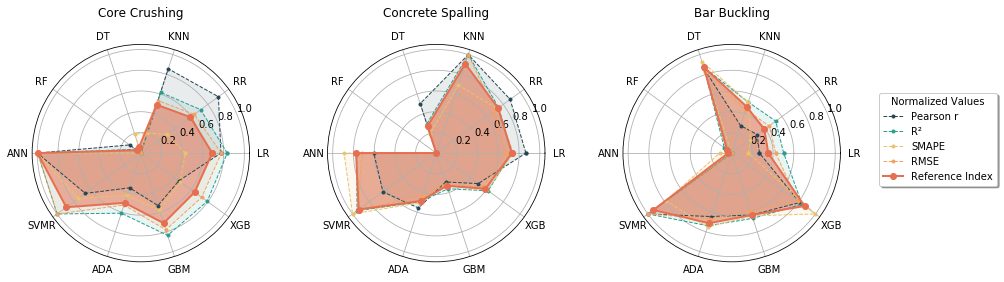

In [39]:
labels=np.array(['LR', 'RR', 'KNN', 'DT', 'RF', 'ANN', 'SVMR', 'ADA', 'GBM', 'XGB'])
models = {0:'LR', 1:'RR', 2:'KNN', 3:'DT', 4:'RF', 5:'ANN', 6:'SVMR', 7:'ADA', 8:'GBM', 9:'XGB'}
best_1, best_2, best_3 = [],[],[]
best_model = {0: best_1,1: best_2,2: best_3}
title_lbl= {0:'Core Crushing', 1:'Concrete Spalling', 2:'Bar Buckling'}
legend_lbl=np.array(['Pearson r','R²','SMAPE','RMSE','Reference Index'])
varlist_1 = {0: best_lr_1, 1:best_rr_1, 2:best_knn_1, 3:best_dt_1, 4:best_rf_1, 5:best_nn_1, 6:best_svmr_1, 7:best_ada_1, 8:best_gbm_1, 9:best_xgbr_1}
varlist_2 = {0: best_lr_2, 1:best_rr_2, 2:best_knn_2, 3:best_dt_2, 4:best_rf_2, 5:best_nn_2, 6:best_svmr_2, 7:best_ada_2, 8:best_gbm_2, 9:best_xgbr_2}
varlist_3 = {0: best_lr_3, 1:best_rr_3, 2:best_knn_3, 3:best_dt_3, 4:best_rf_3, 5:best_nn_3, 6:best_svmr_3, 7:best_ada_3, 8:best_gbm_3, 9:best_xgbr_3}
list_of_lists= {0:varlist_1, 1:varlist_2, 2:varlist_3}

palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15,4))

for i in range(len(list_of_lists)):
    plt_title = title_lbl.get(i) 
    radial_r, radial_r2, radial_SMAPE, radial_RMSE, radial_RefIDX = [], [], [], [], []
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    for j in range(len(list_of_lists[i])):
        radial_r.append(list_of_lists[i][j].at[0,'r'])
        radial_r2.append(list_of_lists[i][j].at[0,'r2'])
        radial_SMAPE.append(list_of_lists[i][j].at[0,'SMAPE'])
        radial_RMSE.append(list_of_lists[i][j].at[0,'RMSE'])    

    angles=np.concatenate((angles,[angles[0]]))
    radial_r=np.concatenate((radial_r,[radial_r[0]]))
    radial_r2=np.concatenate((radial_r2,[radial_r2[0]]))
    radial_SMAPE=np.concatenate((radial_SMAPE,[radial_SMAPE[0]]))
    radial_RMSE=np.concatenate((radial_RMSE,[radial_RMSE[0]]))
    radial_r = Norm(radial_r)
    radial_r2 = Norm(radial_r2)
    radial_SMAPE = Norm_inv(radial_SMAPE)
    radial_RMSE = Norm_inv(radial_RMSE)
    radialplt= {0:radial_r, 1:radial_r2, 2:radial_SMAPE, 3:radial_RMSE}
    radial_RefIDX = List_AVG(radial_r, radial_r2, radial_SMAPE, radial_RMSE)
    
    for j in range(len(radialplt)):
        ax[i].plot(angles, radialplt[j], marker = '.', ls = '--', lw = 1, alpha=1)
        ax[i].fill(angles, radialplt[j], alpha=0.1)
    
    ax[i].plot(angles, radial_RefIDX, 'o-', alpha=1, lw = 2)
    ax[i].fill(angles, radial_RefIDX, alpha=.5)
    ax[i].set_thetagrids(angles[:10] * 180/np.pi, labels)
    ax[i].set_title(plt_title, y=1.1)
    best_model[i] = (radial_RefIDX[:10])
    print("Best",title_lbl[i], "Model:",models.get(best_model[i].index(max(best_model[i]))))
ax[2].legend(legend_lbl,title="Normalized Values",loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)


In [40]:
best_nn_1

,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE
0,128,128,96,2,0.853,0.400,27.960,0.678


In [41]:
best_svmr_2

,Kern,C,degr,eps,r,r2,SMAPE,RMSE
0,3,100,5,0.100,0.435,0.071,29.101,0.925


In [42]:
best_svmr_3

,Kern,C,degr,eps,r,r2,SMAPE,RMSE
0,2,1000,3,0.100,0.883,0.774,24.196,1.781


## Create Scatter Plots for Manuscript

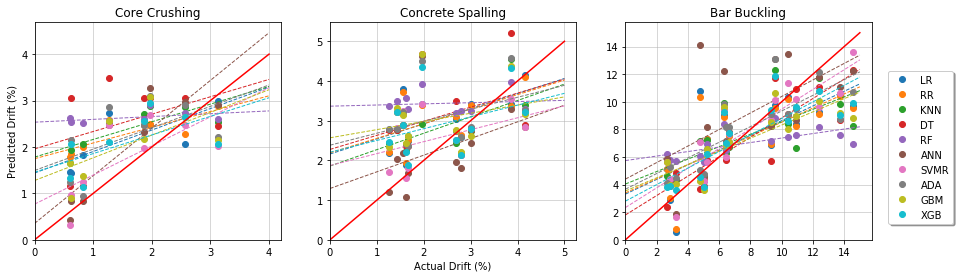

In [43]:
legend_lbl=np.array(['LR', 'RR', 'KNN', 'DT', 'RF', 'ANN', 'SVMR', 'ADA', 'GBM', 'XGB'])
title_lbl= {0:'Core Crushing', 1:'Concrete Spalling', 2:'Bar Buckling'}

y_list_1= {0:pred_y_lr_1, 1:pred_y_rr_1, 2:pred_y_knn_1, 3:pred_y_dt_1, 4:pred_y_rf_1, 5:pred_y_nn_1, 6:pred_y_svmr_1, 7:pred_y_ada_1, 8:pred_y_gbm_1, 9:pred_y_xgbr_1}
y_list_2= {0:pred_y_lr_2, 1:pred_y_rr_2, 2:pred_y_knn_2, 3:pred_y_dt_2, 4:pred_y_rf_2, 5:pred_y_nn_2, 6:pred_y_svmr_2, 7:pred_y_ada_2, 8:pred_y_gbm_2, 9:pred_y_xgbr_2}
y_list_3= {0:pred_y_lr_3, 1:pred_y_rr_3, 2:pred_y_knn_3, 3:pred_y_dt_3, 4:pred_y_rf_3, 5:pred_y_nn_3, 6:pred_y_svmr_3, 7:pred_y_ada_3, 8:pred_y_gbm_3, 9:pred_y_xgbr_3}
perf_fit = [[0,4],[0,5],[0,15]]
x_list= {0:test_y_1, 1:test_y_2, 2:test_y_3}
y_all= {0:y_list_1, 1:y_list_2, 2:y_list_3}

palette = ["#BCABAE", "#0F0F0F", "#2D2E2E", "#716969", "#FBFBFB", "#D4E09B", "#A44A3F", "#BFEDEF", "#98E2C6", "#62BFED"]
palette = sns.color_palette("tab10")
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15,4))
lgnd_h = []
for i in range(len(y_all)):
    plt_title = title_lbl.get(i) 
    for j in range(len(labels)):
        ax[i].plot(x_list.get(i),y_all.get(i).get(j), marker = 'o', lw = 0)
        if i == 0:
            lgnd_h.append(Line2D(x_list.get(i),y_all.get(i).get(j), marker = 'o', color= palette[j], lw = 0))
        # Display Linear Trendline for each series
        trend_x = np.polyfit(x_list.get(i), y_all.get(i).get(j), 1)
        trend_fit = np.poly1d(trend_x)
        ax[i].plot([0,perf_fit[i][1]],[trend_fit(0),trend_fit(perf_fit[i][1])], color= palette[j],ls = '--',lw = 1)
    ax[i].plot(perf_fit[i],perf_fit[i], 'r-', lw = 1.5)
    ax[i].set_title(plt_title, y=1)
    ax[i].set_ylim(bottom=0); ax[i].set_xlim(left=0)
    ax[i].grid(linestyle='-', linewidth=0.5)
ax[0].set_ylabel('Predicted Drift (%)')
ax[1].set_xlabel('Actual Drift (%)')
ax[2].legend(handles =lgnd_h, labels = list(legend_lbl), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

## Plot Histograms for Manuscript

Text(0, 0.5, 'frequency')

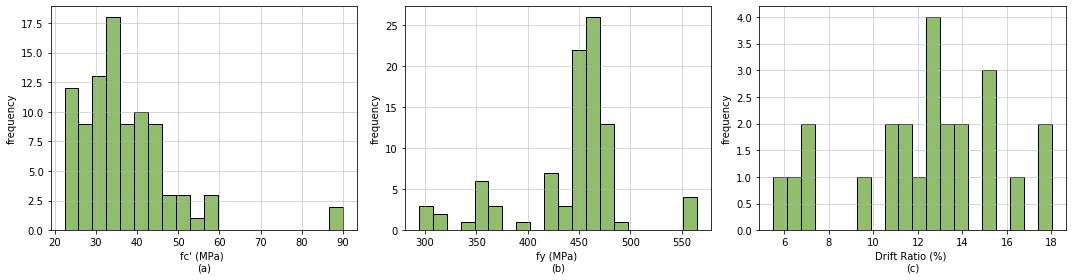

In [44]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(15,4))
n_bins = 20
ax[0].grid(linestyle='-', linewidth=0.5)
ax[0].hist(X[:,1], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[0].set_xlabel("fc' (MPa) \n(a)")
ax[0].set_ylabel("frequency")

ax[1].grid(linestyle='-', linewidth=0.5)
ax[1].hist(X[:,3], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[1].set_xlabel("fy (MPa) \n(b)")
ax[1].set_ylabel("frequency")

ax[2].grid(linestyle='-', linewidth=0.5)
Hist_Y = Y[:,0]+Y[:,1]+Y[:,2]
ax[2].hist(Hist_Y, bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[2].set_xlabel("Drift Ratio (%) \n(c)")
ax[2].set_ylabel("frequency")

## Comparison With Existing Methods

In [54]:
def Method_Comparison(actual, prediction):
    pred_ratio = []
    for i in range(len(actual)):
        pred_ratio.append(actual[i]/prediction[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov

def Berry_Spalling(properties, actual):
    pred_cs,pred_ratio = [], []
    values = np.array(properties)
    for i in range(size(properties,0)):
        pred_cs.append(1.6*(1-values[i][0])*(1+(0.1*values[i][2])))
    for i in range(size(properties,0)):
        pred_ratio.append(actual[i]/pred_cs[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov, pred_cs

def Berry_Buckling(properties, actual):
    pred_bb,pred_ratio = [], []
    values = np.array(properties)
    for i in range(size(properties,0)):
        pred_bb.append(3.25*(1+150*((values[i][6]/100*values[i][5])/values[i][1])*(values[i][8]/values[i][7]))*(1-values[i][0])*(1+(0.1*values[i][2])))
    for i in range(size(properties,0)):
        pred_ratio.append(actual[i]/pred_bb[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov, pred_bb

def Goodnight_Buckling(properties, actual):
    pred_bb,pred_ratio = [], []
    values = np.array(properties)
    for i in range(size(properties,0)):
        pred_bb.append(0.9-(3.13*values[i][0])+(1420*values[i][6]*values[i][5]/200000)+(0.45*values[i][2]))
    for i in range(size(properties,0)):
        pred_ratio.append(actual[i]/pred_bb[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov, pred_bb

if FILE_PATH == 'Circ_Dataset.xlsx':
    csB_ratio, csB_cov, pred_y_berry_2 = Berry_Spalling(test_x_original_2,test_y_2)
    cs_ratio, cs_cov = Method_Comparison(test_y_2,pred_y_svmr_2);####
    print("Circular Concrete Spalling \t\tAcc: ",cs_ratio, "|  COV: ",cs_cov)
    print("Berry & Eberhard Concrete Spalling \tAcc: ",csB_ratio, "|  COV: ",csB_cov)
    print("Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio: ",round((-100*(cs_ratio-csB_ratio)/(csB_ratio)),2),"%", "|  COV: ",round((csB_cov-cs_cov)/(csB_cov/100),2),"%",'\n')
    
    bbB_ratio, bbB_cov, pred_y_berry_3 = Berry_Buckling(test_xbe_original_3,test_y_3)
    bbG_ratio, bbG_cov, pred_y_goodnight_3 = Goodnight_Buckling(test_xbe_original_3,test_y_3)
    bb_ratio, bb_cov = Method_Comparison(test_y_3,pred_y_svmr_3);####
    print("Circular Bar Buckling \tAcc: ",bb_ratio, "|  COV: ",bb_cov)
    print("Berry & Eberhard Bar Buckling \tAcc: ",bbB_ratio, "|  COV: ",bbB_cov)
    print("Goodnight et al. Bar Buckling \tAcc: ",bbG_ratio, "|  COV: ",bbG_cov)
    print("Improvement over Berry & Eberhard (2005) Bar Buckling Ratio: ",round((-100*(bb_ratio-bbB_ratio)/(bbB_ratio)),2),"%","|  COV: ",round((bbB_cov-bb_cov)/(bbB_cov/100),2),"%")
    print("Improvement over Goodnight et al. (2015) Bar Buckling Ratio: ",round((-100*(bb_ratio-bbG_ratio)/(bbG_ratio)),2),"%","|  COV: ",round((bbG_cov-bb_cov)/(bbG_cov/100),2),"%",'\n')


Circular Concrete Spalling 		Acc:  0.9325509662599768 |  COV:  33.13604770063719
Berry & Eberhard Concrete Spalling 	Acc:  1.2619688401240994 |  COV:  34.595049993394525
Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio:  26.1 % |  COV:  4.22 % 

Circular Bar Buckling 	Acc:  1.0075720055497466 |  COV:  32.96692672354691
Berry & Eberhard Bar Buckling 	Acc:  1.5067051807943628 |  COV:  41.566137700009946
Goodnight et al. Bar Buckling 	Acc:  1.199025560500633 |  COV:  37.52016746391004
Improvement over Berry & Eberhard (2005) Bar Buckling Ratio:  33.13 % |  COV:  20.69 %
Improvement over Goodnight et al. (2015) Bar Buckling Ratio:  15.97 % |  COV:  12.14 % 



# Plot SHAP Summary Diagrams for Manuscript

In [46]:
# initialize optimal models for explainer
model1 = xgb.XGBRegressor(n_estimators= 500, learning_rate= 0.250, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=5, random_state = seed)
model1.fit(train_x, train_y[:,0])

model2 = xgb.XGBRegressor(n_estimators= 500, learning_rate= 0.250, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=5, random_state = seed)
model2.fit(train_x, train_y[:,1])

model3 = xgb.XGBRegressor(n_estimators= 500, learning_rate= 0.250, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=5, random_state = seed)
model3.fit(train_x, train_y[:,2])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1,
             random_state=4191995, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.75, tree_method='exact',
             validate_parameters=1, verbosity=None)

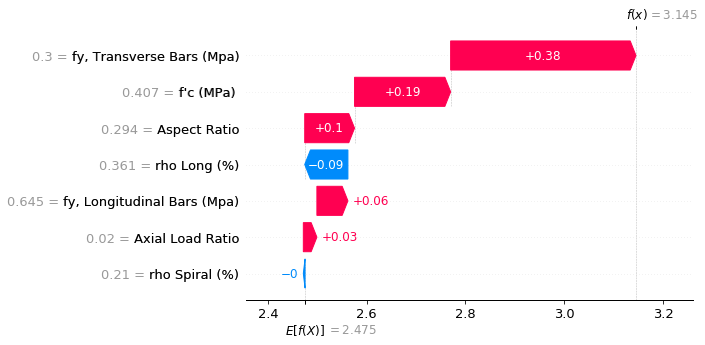

In [47]:
df = pd.read_excel(FILE_PATH)
X_shap = pd.DataFrame(X_, columns = df.columns[1:8])

background = shap.maskers.Independent(X_)
explainer = shap.Explainer(model1, background)
shap_values = explainer(X_shap)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

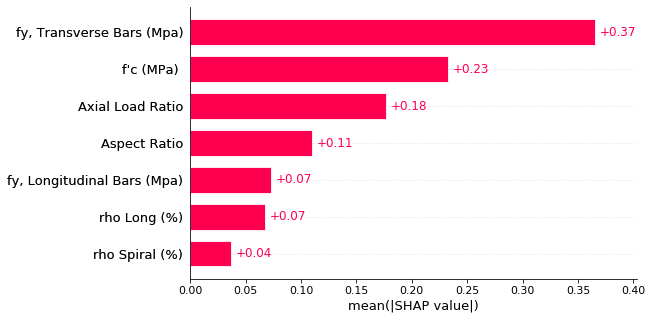

In [48]:
# plot the global importance of each feature in the core crushing model
explainer = shap.Explainer(model1)
shap_values = explainer(X_shap)
shap.plots.bar(shap_values)

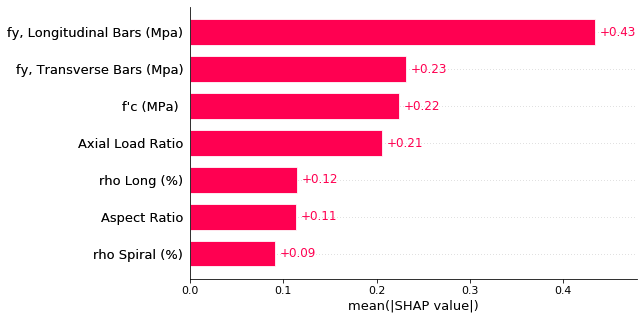

In [49]:
# plot the global importance of each feature in the cover spalling model
explainer = shap.Explainer(model2)
shap_values = explainer(X_shap)
shap.plots.bar(shap_values)

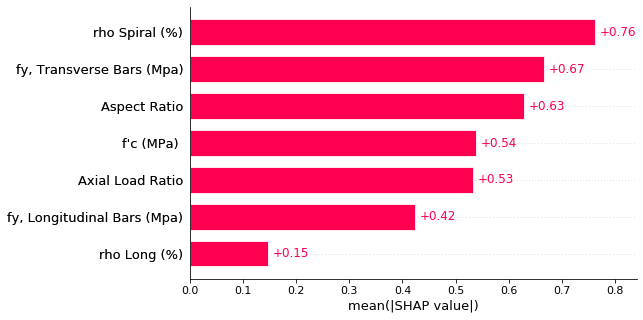

In [50]:
# plot the global importance of each feature in the bar buckling model
explainer = shap.Explainer(model3)
shap_values = explainer(X_shap)
shap.plots.bar(shap_values)

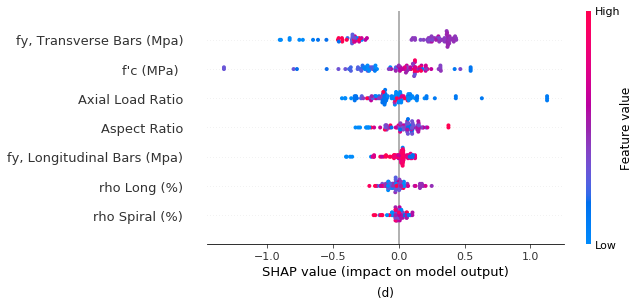

In [51]:
df = pd.read_excel(FILE_PATH)
X_shap = pd.DataFrame(X_, columns = df.columns[1:8])

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_shap)

# Plot the summary
plt.figure()
plt.title('(d)',y=-.25)
shap.summary_plot(shap_values, X_shap)

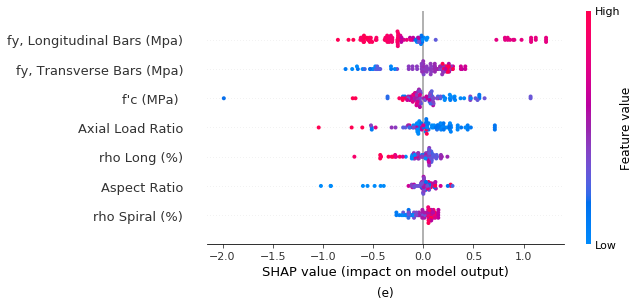

In [52]:
df = pd.read_excel(FILE_PATH)
X_shap = pd.DataFrame(X_, columns = df.columns[1:8])

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_shap)

# Plot the summary
plt.figure()
plt.title('(e)',y=-.25)
shap.summary_plot(shap_values, X_shap)

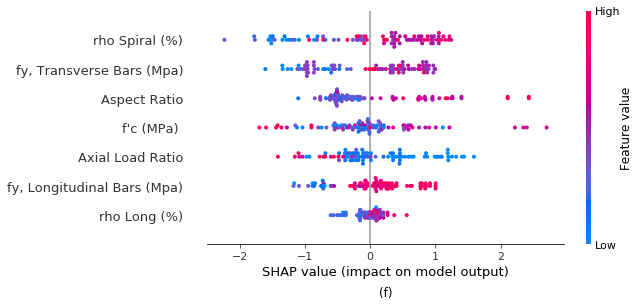

In [53]:
df = pd.read_excel(FILE_PATH)
X_shap = pd.DataFrame(X_, columns = df.columns[1:8])

explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_shap)

# Plot the summary
plt.figure()
plt.title('(f)',y=-.25)
shap.summary_plot(shap_values, X_shap)